## Settings

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

In [1]:
import pandas as pd
import numpy as np
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
import matplotlib.pyplot as plt
from plotly import tools
import scipy.stats as sp
from scipy.stats import t
from scipy.optimize import fmin
from scipy.optimize import minimize
import math
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.linalg import eigh, cholesky
from scipy.stats import norm
#from pylab import plot, show, axis, subplot, xlabel, ylabel, grid
%matplotlib inline

In [3]:
apiKey = 'lQg24SpLGpWSL3Yn35VS'
plotly.tools.set_credentials_file(username='amcdonne', api_key=apiKey)
plotly.tools.set_config_file(world_readable=False, sharing='private')

# (i) Firm Value

### (a) Simulate the value of the firm 250,000 times over a 20 year period using the Merton Model

Numerical PD:  0.32498400000000005 

Estimated Distribution PD:  0.31992505264026716


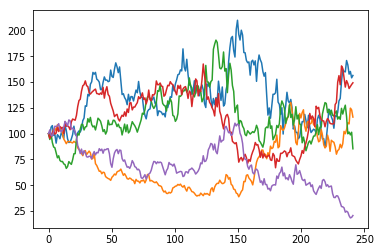

In [68]:
'''
V: Starting Firm Value @ t_0
K: Face Value of Debt @ T (Strike Price) **** Variable not used in the model
sigma: The Volatility of Assets or Firm value for a specified time period
dt: Time Step
iRate: Quoted Annual Interest Rate
num_paths: The number of paths that will be simulated

Notes: Model starts with the given details of Firm value and then generates a monte carlo simulation based on the number of paths,
scaled volatility, time step and interest rate
'''
def merton_model(V, K, sigma, T, dt, iRate, num_paths):
    num_periods = int(T*dt**-1)
    #Creates a matrix filled with zeros; Rows: num_paths, Columns: num_periods
    asset_value = np.zeros((num_periods + 1, int(num_paths)))
    asset_value[0] = V
    for t in range(1, num_periods+1):
        if t > num_periods/2:
            sigma = .25
        # The stochastic equation for simulating the firm value
        asset_value[t] = asset_value[t-1]*np.exp((iRate -.5*sigma**2)*dt + sigma*np.random.randn(num_paths)*np.sqrt(dt))
    print('Numerical PD: ', 1 - (np.sum(asset_value[-1, :] > K)/ num_paths), '\n')
    print('Estimated Distribution PD: ', sp.gaussian_kde(np.array(asset_value[-1,:])).integrate_box_1d(-np.inf, K))
    
    fig = plt.figure()
    ax = plt.axes()
    x = np.linspace(0, 241, num=241)
    ax.plot(x, asset_value[:,np.random.randint(250000)],
             x, asset_value[:,np.random.randint(250000)],
             x, asset_value[:,np.random.randint(250000)],
             x, asset_value[:,np.random.randint(250000)],
             x, asset_value[:,np.random.randint(250000)])
    
    
    return asset_value#1 - (np.sum(asset_value[-1, :] > K)/ num_paths)#asset_value

simulated_asset_values = merton_model(V=100, K=80, sigma=.15, T=20, dt=1/12, iRate=0.031, num_paths=250000)

In [5]:
def plot_simulation(simulated_values, model_type, num_paths):
    trace0 = go.Scatter(
    y = simulated_values[:,np.random.randint(num_paths)],
    mode = 'lines',
    name = 'Path 1'
    )
    trace1 = go.Scatter(
        y = simulated_values[:,np.random.randint(num_paths)],
        mode = 'lines',
        name = 'Path 2'
    )
    trace2 = go.Scatter(
        y = simulated_values[:,np.random.randint(num_paths)],
        mode = 'lines',
        name = 'Path 3'
    )
    trace3 = go.Scatter(
        y = simulated_values[:,np.random.randint(num_paths)],
        mode = 'lines',
        name = 'Path 4'
    )
    trace4 = go.Scatter(
        y = simulated_values[:,np.random.randint(num_paths)],
        mode = 'lines',
        name = 'Path 5'
    )
    data = [trace0, trace1, trace2, trace3, trace4]
    layout = dict(title = str(model_type) + 'Asset Value Simulation',
                  xaxis = dict(title = 'Time Period in months'),
                  yaxis = dict(title = 'Asset Value'),
                  )

    fig = dict(data=data, layout=layout)
    
    return py.iplot(fig, filename='Credit-Risk' + str(model_type))

In [6]:
plot_simulation(simulated_asset_values, 'Merton Model', num_paths=250000)

C:\Users\austi\Anaconda\lib\site-packages\IPython\core\display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



### (b) Plot Residual Firm Values

In [69]:
# Calculate the simple residual firm values by subtracting the face value of debt from the simulated asset values
residual_firm_value = simulated_asset_values - 80

# Plotly Histogram chart of the residual asset values @ Maturity (T=T)
data = [go.Histogram(x=residual_firm_value[-1,:])]
layout = dict(title = 'Asset Values at T Histogram',
              xaxis = dict(title = 'Firm Value Bins'),
              yaxis = dict(title = 'Number of Observations'),
              )

fig = dict(data=data, layout=layout)
py.iplot(fig, filename='Credit-Risk-Merton_Distribution')

C:\Users\austi\Anaconda\lib\site-packages\plotly-3.3.0-py3.7.egg\plotly\plotly\plotly.py:230: UserWarning:

Woah there! Look at all those points! Due to browser limitations, the Plotly SVG drawing functions have a hard time graphing more than 500k data points for line charts, or 40k points for other types of charts. Here are some suggestions:
(1) Use the `plotly.graph_objs.Scattergl` trace object to generate a WebGl graph.
(2) Trying using the image API to return an image instead of a graph URL
(3) Use matplotlib
(4) See if you can create your visualization with fewer data points

If the visualization you're using aggregates points (e.g., box plot, histogram, etc.) you can disregard this warning.

C:\Users\austi\Anaconda\lib\site-packages\IPython\core\display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



In [8]:
# Seaborn plot of the residual asset values @ Maturity T=T
#sns.distplot(residual_firm_value[-1,:], hist=False, rug=True);

### (c) Default Probability @ T

In [72]:
'''
Notes: Calculates the "Analytical Default Probability" based on the values of N(-d2) derived from the Call option from the Equity
calculation. This accounts for the split sigma's given at 10 year intervals

TODO: Check to see if the variances can be combined or D2's multiplied together
'''

def analytical_default_probability(V_0, K, sigma_10, sigma_20, T, iRate):
    
    d1_10 = (np.log(V_0/K) + (iRate + .5*sigma_10**2)*T/2)/ (sigma_10*np.sqrt(T/2))
    d2_10 = d1_10 - (sigma_10)*np.sqrt(T/2)
    d1_20 = (np.log(V_0/K) + (iRate + .5*sigma_20**2)*T/2)/ (sigma_20*np.sqrt(T/2))
    d2_20 = d1_20 - (sigma_20)*np.sqrt(T/2)
    print(sp.norm.cdf(d2_10))
    print(sp.norm.cdf(d2_20))
    
    return print('Product of multiple leg Probability of Default: ', sp.norm.cdf(d2_10) * sp.norm.cdf(d2_20))
    #print(sp.norm.pdf(d1))
    #print(sp.norm.pdf(d2))
    #print(sp.norm.pdf(-d2))
    #equity_0 = V_0*sp.norm.cdf(d1) - K*np.exp(-iRate*T)*sp.norm.cdf(d2)
    #return ('Call Option Price: ' + str(round(equity_0, 2)),'Probabilty of Default @ T: ' + str(round(sp.norm.cdf(-d2)*100, 2)) + '%')

analytical_default_probability(V_0=100, K=80, sigma_10=.15, sigma_20= .25, T=20, iRate=0.031)

0.8124052173144941
0.6099138362774877
Product of multiple leg Probability of Default:  0.49549718270412924


In [10]:
# Generates a probability distribution based on an array of numbers
kde = sp.gaussian_kde(np.array(simulated_asset_values[-1,:]))

#get probability from the integral of the assumed probability distribution from the ending asset values; from negative infinity to 80
'''
print('PD Output 1: ', sp.gaussian_kde(np.array(
    merton_model(V=100, K=80, sigma=.15, T=20, dt=1/12, iRate=0.031, num_paths=250000)[-1,:])).integrate_box_1d(-np.inf, 80), '\n')
print('PD Output 2: ', sp.gaussian_kde(np.array(
    merton_model(V=100, K=80, sigma=.15, T=20, dt=1/12, iRate=0.031, num_paths=250000)[-1,:])).integrate_box_1d(-np.inf, 80), '\n')
print('PD Output 3: ', sp.gaussian_kde(np.array(
    merton_model(V=100, K=80, sigma=.15, T=20, dt=1/12, iRate=0.031, num_paths=250000)[-1,:])).integrate_box_1d(-np.inf, 80), '\n')
print('PD Output 4: ', sp.gaussian_kde(np.array(
    merton_model(V=100, K=80, sigma=.15, T=20, dt=1/12, iRate=0.031, num_paths=250000)[-1,:])).integrate_box_1d(-np.inf, 80))
'''

merton_default_probability = kde.integrate_box_1d(-np.inf, 80)
print('Base Model Output: ', merton_default_probability, '\n')

Base Model Output:  0.32091343019132723 



### (d) Black Cox Model: Stopping time of default

In [36]:
'''
V: Starting Firm Value @ t_0
K: Face Value of Debt @ T (Strike Price) 
sigma: The Volatility of Assets or Firm value for a specified time period
dt: Time Step
iRate: Quoted Annual Interest Rate
num_paths: The number of paths that will be simulated

Notes: Model starts with the given details of Firm value and then generates a monte carlo simulation based on the number of paths,
scaled volatility, time step and interest rate. The asset values at each path is then compared to the discounted face value of debt (K)
at each time step. If the Assets are less than the discounted fave value of debt then a default at t < T is flagged in a binary a matrix
'''

def black_cox_model(V, K, sigma, T, dt, iRate, num_paths):
    num_periods = int(T*dt**-1)
    #Creates a matrix filled with zeros; Rows: num_paths, Columns: num_periods
    asset_value = np.zeros((num_periods + 1, int(num_paths)))
    non_default_binary = np.zeros((num_periods + 1, int(num_paths)))
    asset_value[0] = V
    non_default_binary[0] = V >= K*np.exp(-iRate*T)
    for t in range(1, num_periods+1):
        if t > num_periods/2:
            sigma = .25
        # The stochastic equation for simulating the firm value
        asset_value[t] = asset_value[t-1]*np.exp((iRate -.5*sigma**2)*dt + sigma*np.random.randn(num_paths)*np.sqrt(dt))
        #checks to see if the current asset values are greater than the discounted Face value of debt
        non_default_binary[t] = asset_value[t] > K*np.exp(-iRate*(T-(t*dt)))
        
    # sums up all of the instances where there was not a default; ie. each row is equal to the num_periods + 1 if there was not a default
    binary_default_array = (np.sum(non_default_binary, axis=0)) == (num_periods+1)
    # Returns the percentage of paths that defaulted throught the period of T_0 through T
    print('Numerical PD: ', 1 - (np.sum(binary_default_array)/ num_paths))
    # Multiplies the binary non-default matrix with the asset values matrix at Time = T
    final_values = asset_value[-1,:] * binary_default_array
    return 1 - (np.sum(binary_default_array)/ num_paths)#sp.gaussian_kde(final_values).integrate_box_1d(-np.inf, K)

black_cox_default_probability = black_cox_model(V=100, K=80, sigma=.15, T=20, dt=1/12, iRate=0.031, num_paths=250000)

print('Estimated Distribution PD Model 2: ', black_cox_default_probability)

Numerical PD:  0.49652399999999997
Estimated Distribution PD Model 2:  0.49652399999999997


### (f) Changing the debt structure to equal out the probabilities

In [37]:
def merton_model_prob_default(V, K, sigma, T, dt, iRate, num_paths):
    num_periods = int(T*dt**-1)
    #Creates a matrix filled with zeros; Rows: num_paths, Columns: num_periods
    asset_value = np.zeros((num_periods + 1, int(num_paths)))
    asset_value[0] = V
    for t in range(1, num_periods+1):
        if t > num_periods/2:
            sigma = .25
        # The stochastic equation for simulating the firm value
        asset_value[t] = asset_value[t-1]*np.exp((iRate -.5*sigma**2)*dt + sigma*np.random.randn(num_paths)*np.sqrt(dt))
    # creates a PDF from the data and then integrates over that PDF from negative infinity to K to find the probability of falling in this region
    print('Numerical PD: ', 1 - (np.sum(asset_value[-1, :] > K)/ num_paths), '\n')
    kde = sp.gaussian_kde(np.array(asset_value[-1,:]))
    return kde.integrate_box_1d(-np.inf, K)

def search_probability_merton(K):
    #kde = sp.gaussian_kde(np.array(simulated_asset_values[-1,:]))
    return sp.gaussian_kde(np.array(simulated_asset_values[-1,:])).integrate_box_1d(-np.inf, K)

'''
Sets up the optimization problem between the Merton and Black Cox Model.

The function takes the previously simulated values of the Merton Model and locks the PD.
A minimization objective function is run against the locked Merton PD and the variable Black Cox PD by changing the leverage amount
'''
def probability_errors(debt_level):
    black_cox= black_cox_model(V=100, K= debt_level, sigma=.15, T=20, dt=1/12, iRate=0.031, num_paths=250000)
    merton= simulated_asset_values#search_probability_merton(debt_level)#merton_model_prob_default(V=100, K=debt_level, sigma=.15, T=20, dt=1/12, iRate=0.031, num_paths=250000)
    #merton_default_probability
    error = (merton - black_cox)**2
    print('Debt: ', debt_level, '\nError: ', error)
    return error
parameters = 80

In [13]:
'''
This is the debt level to tie out to the merton model numerical default probability
'''
black_cox_model(V=100, K= 57.5, sigma=.15, T=20, dt=1/12, iRate=0.031, num_paths=250000)

Numerical PD:  0.32407600000000003


0.3397426724364491

Numerical PD:  0.20962000000000003 

Estimated Distribution PD:  0.2090447174663236


array([[100.        , 100.        , 100.        , ..., 100.        ,
        100.        , 100.        ],
       [ 94.7610028 , 102.79645703,  94.31827358, ..., 104.34495227,
         96.01198452, 103.86166202],
       [ 89.40802146, 100.58159532,  97.16505557, ..., 104.22465098,
         95.22231467,  99.54591394],
       ...,
       [259.76283761, 200.18926371, 186.70965385, ..., 172.19227196,
         32.45412392,  36.75570928],
       [287.487847  , 204.94089066, 212.99059266, ..., 171.5668397 ,
         31.10982469,  37.22748852],
       [313.02485272, 181.50464477, 196.66121232, ..., 176.9109755 ,
         31.23245997,  38.41922457]])

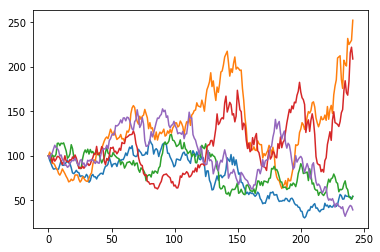

In [34]:
merton_model(V=100, K= 57.5, sigma=.15, T=20, dt=1/12, iRate=0.031, num_paths=250000)

In [ ]:
0.32407600000000003

In [38]:
'''
debt level of 54.57497857 for changing K only in BC to match the Locked K and values of Merton Model: 3.2476042971524785e-06 error
'''
res = minimize(fun=probability_errors, x0=parameters, bounds=((0, 200),))

Numerical PD:  0.49824
Debt:  [80.] 
Error:  0.029821145344000023
Numerical PD:  0.49959600000000004
Debt:  [80.00000001] 
Error:  0.03029131393600003
Numerical PD:  0.0
Debt:  [0.] 
Error:  0.10598410470399997
Numerical PD:  0.0
Debt:  [1.e-08] 
Error:  0.10598410470399997
Numerical PD:  0.28780799999999995
Debt:  [53.33333441] 
Error:  0.0014246095359999999
Numerical PD:  0.28857600000000005
Debt:  [53.33333442] 
Error:  0.0013672245759999925
Numerical PD:  0.427492
Debt:  [70.56739201] 
Error:  0.010391763600000006
Numerical PD:  0.42765200000000003
Debt:  [70.56739202] 
Error:  0.010424410000000016
Numerical PD:  0.477492
Debt:  [76.96754919] 
Error:  0.023085763600000024
Numerical PD:  0.476904
Debt:  [76.9675492] 
Error:  0.02290742790400001
Numerical PD:  0.48871200000000004
Debt:  [78.78636762] 
Error:  0.026621185600000027
Numerical PD:  0.490128
Debt:  [78.78636763] 
Error:  0.027085259776000018
Numerical PD:  0.496212
Debt:  [79.74256472] 
Error:  0.029124835600000013
Numeri

KeyboardInterrupt: 

### (h) Change in Defualt Probabilities with dt = 1

In [15]:
print('Black Cox Default Probability (dt = 1/12): ', black_cox_default_probability, '\n')
print('Black Cox Default Probability (dt = 1): ', black_cox_model(V=100, K=80, sigma=.15, T=20, dt=1, iRate=0.031, num_paths=250000), '\n')
print('Merton Default Probability (dt = 1/12): ', merton_default_probability, '\n')
print('Merton Default Probability (dt = 1): ', merton_model_prob_default(V=100, K=80, sigma=.15, T=20, dt=1, iRate=0.031, num_paths=250000))

Black Cox Default Probability (dt = 1/12):  0.5078033166355741 

Numerical PD:  0.44721200000000005
Black Cox Default Probability (dt = 1):  0.46351140690490217 

Merton Default Probability (dt = 1/12):  0.32091343019132723 

Numerical PD:  0.32485600000000003 

Merton Default Probability (dt = 1):  0.32063954649741866


# (ii) Merton Model Credit Spreads

### (a) Credit Spread Function of time to maturity

In [39]:
def spreads(firm_values, maturity, iRate, fv_debt, sigma_asset, model_type):
    if model_type == 'jump_diffusion':
        lam = float(input("Enter Lambda Value: "))
        mu = float(input(" Enter Mean Jump Value: "))
        sig = float(input(" Enter Sigma Jump Value: "))
    spread_matrix = []
    for value in firm_value:
        spread_list = []
        for T in maturity:
            if model_type == 'jump_diffusion':
                #keeping Lambda low here for this calculation
                call_option_value = jump_diffustion_option_pricing(firm_value=value, fv_debt=fv_debt, T=T, sigma=sigma_asset, rf=iRate,
                                                                   Lambda=lam, jump_mean=mu, jump_sigma=sig, num_periods=50)
            else:
                d1 = (np.log(value/fv_debt) + (iRate + .5*sigma_asset**2)*T)/ (sigma_asset*np.sqrt(T))
                d2 = d1 - (sigma_asset)*np.sqrt(T)
                #risky_bond_value = fv_debt*np.exp((-iRate)*T) - fv_debt*np.exp((-iRate)*T)*sp.norm.cdf(-d2) - value*sp.norm.cdf(-d1)
                call_option_value = value*sp.norm.cdf(d1) - fv_debt*np.exp((-iRate)*T)*sp.norm.cdf(d2)
            
            bond_option_value = value - call_option_value
            risky_yield = 1/T * np.log(fv_debt/bond_option_value)
            spread = risky_yield - iRate
            spread_list.append(spread)
        spread_matrix.append(spread_list)
    return pd.DataFrame(data=np.array(spread_matrix), index=firm_values, columns=maturity).T*10000

In [54]:
firm_value = [80, 90, 125, 180]
time = np.arange(0.5, 10.5, 0.5)
bs_spreads = spreads(firm_values=firm_value, maturity=time, iRate=0.028, fv_debt=95, sigma_asset=.23, model_type = 'black_scholes')

model_type = 'Black Scholes'
trace0 = go.Scatter(
    y = list(round(bs_spreads.iloc[:,0])),
    x = bs_spreads.index,
    mode = 'lines',
    name = 'Firm Value: 80'
)
trace1 = go.Scatter(
    y = list(round(bs_spreads.iloc[:,1])),
    x = bs_spreads.index,
    mode = 'lines',
    name = 'Firm Value: 90'
)
trace2 = go.Scatter(
    y = list(round(bs_spreads.iloc[:,2])),
    x = bs_spreads.index,
    mode = 'lines',
    name = 'Firm Value: 125'
)
trace3 = go.Scatter(
    y = list(round(bs_spreads.iloc[:,3])),
    x = bs_spreads.index,
    mode = 'lines',
    name = 'Firm Value: 180'
)
data = [trace0, trace1, trace2, trace3]
layout = dict(title = str(model_type) + ' Credit Spreads',
              xaxis = dict(title = 'Time in Years'),
              yaxis = dict(title = 'Basis Points'),
              )

fig = dict(data=data, layout=layout)

py.iplot(fig, filename='Credit-Risk-BS_Credit_Spreads')

C:\Users\austi\Anaconda\lib\site-packages\IPython\core\display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



### (b) Plotting Credit Spread as a function of time to maturity

In [55]:
vol = [.15, .20, .30, .50]
time = np.arange(0, 10.5, 0.5)
def spreads_vol(value, maturity, iRate, fv_debt, sigmas):
    spread_matrix = []
    for sigma_asset in sigmas:
        spread_list = []
        for T in maturity:
            d1 = (np.log(value/fv_debt) + (iRate + .5*sigma_asset**2)*T)/ (sigma_asset*np.sqrt(T))
            d2 = d1 - (sigma_asset)*np.sqrt(T)
            #risky_bond_value = fv_debt*np.exp((-iRate)*T) - fv_debt*np.exp((-iRate)*T)*sp.norm.cdf(-d2) - value*sp.norm.cdf(-d1)
            call_option_value = value*sp.norm.cdf(d1) - fv_debt*np.exp((-iRate)*T)*sp.norm.cdf(d2)
            bond_option_value = value - call_option_value
            risky_yield = 1/T * np.log(fv_debt/bond_option_value)
            spread = risky_yield - iRate
            spread_list.append(spread)
        spread_matrix.append(spread_list)
    return pd.DataFrame(data=np.array(spread_matrix), index=vol, columns=maturity).T*10000
bs_spreads_vol = spreads_vol(value=120, maturity=time, iRate=0.028, fv_debt=90, sigmas=vol)

C:\Users\austi\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning:

divide by zero encountered in double_scalars

C:\Users\austi\Anaconda\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning:

divide by zero encountered in double_scalars

C:\Users\austi\Anaconda\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning:

invalid value encountered in double_scalars



In [75]:
bs_spreads_vol.iloc[0] = 0
bs_spreads_vol

,0.15,0.2,0.3,0.5
0.0,0.000000,0.000000,0.000000,0.000000
0.5,1.614744,19.370898,172.308168,910.910860
1.0,11.200660,57.217268,266.288844,967.620637
1.5,20.866526,79.508302,294.973752,937.873391
2.0,27.873785,91.552940,302.507075,898.459591
2.5,32.603671,97.959991,301.871143,860.928720
3.0,35.711980,101.176124,297.768298,827.239098
3.5,37.701131,102.510087,292.170574,797.359040
4.0,38.916127,102.696285,285.986515,770.833633
4.5,39.590040,102.166572,279.659360,747.169419


In [76]:
model_type = 'Black Scholes'
trace0 = go.Scatter(
    y = list(round(bs_spreads_vol.iloc[:,0])),
    x = bs_spreads_vol.index,
    mode = 'lines',
    name = 'Volatility: 15.0%'
)
trace1 = go.Scatter(
    y = list(round(bs_spreads_vol.iloc[:,1])),
    x = bs_spreads_vol.index,
    mode = 'lines',
    name = 'Volatility: 20.0%'
)
trace2 = go.Scatter(
    y = list(round(bs_spreads_vol.iloc[:,2])),
    x = bs_spreads_vol.index,
    mode = 'lines',
    name = 'Volatility: 30.0%'
)
trace3 = go.Scatter(
    y = list(round(bs_spreads_vol.iloc[:,3])),
    x = bs_spreads_vol.index,
    mode = 'lines',
    name = 'Volatility: 50.0%'
)
data = [trace0, trace1, trace2, trace3]
layout = dict(title = str(model_type) + ' Credit Spreads',
              xaxis = dict(title = 'Time in Years'),
              yaxis = dict(title = 'Basis Points'),
              )

fig = dict(data=data, layout=layout)

py.iplot(fig, filename='Credit-Risk-BS_Credit_Spreads_vol')

C:\Users\austi\Anaconda\lib\site-packages\IPython\core\display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



### (c) Complete Table with the credit spread as a function of time to maturity and risk free rate

In [60]:
rf = [0.03, 0.09]
time = np.arange(0.5, 10.5, 0.5)
def spreads_rf(value, maturity, risk_free, fv_debt, sigma_asset):
    spread_matrix = []
    for iRate in risk_free:
        spread_list = []
        for T in maturity:
            d1 = (np.log(value/fv_debt) + (iRate + .5*sigma_asset**2)*T)/ (sigma_asset*np.sqrt(T))
            d2 = d1 - (sigma_asset)*np.sqrt(T)
            #risky_bond_value = fv_debt*np.exp((-iRate)*T) - fv_debt*np.exp((-iRate)*T)*sp.norm.cdf(-d2) - value*sp.norm.cdf(-d1)
            call_option_value = value*sp.norm.cdf(d1) - fv_debt*np.exp((-iRate)*T)*sp.norm.cdf(d2)
            bond_option_value = value - call_option_value
            risky_yield = 1/T * np.log(fv_debt/bond_option_value)
            spread = risky_yield - iRate
            spread_list.append(spread)
        spread_matrix.append(spread_list)
    return pd.DataFrame(data=np.array(spread_matrix), index=risk_free, columns=maturity).T*10000
bs_spreads_rf = spreads_rf(value=120, maturity=time, risk_free=rf, fv_debt=95, sigma_asset=0.18)

model_type = 'Black Scholes'
trace0 = go.Scatter(
    y = list(round(bs_spreads_rf.iloc[:,0])),
    x = bs_spreads_rf.index,
    mode = 'lines',
    name = 'Risk Free Rate: 3.0%'
)
trace1 = go.Scatter(
    y = list(round(bs_spreads_rf.iloc[:,1])),
    x = bs_spreads_rf.index,
    mode = 'lines',
    name = 'Risk Free Rate: 20.0%'
)

data = [trace0, trace1]
layout = dict(title = str(model_type) + ' Credit Spreads',
              xaxis = dict(title = 'Time in Years'),
              yaxis = dict(title = 'Basis Points'),
              )

fig = dict(data=data, layout=layout)

py.iplot(fig, filename='Credit-Risk-BS_Credit_Spreads_rf')

C:\Users\austi\Anaconda\lib\site-packages\IPython\core\display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



# (iii) Merton Model Extensions: Merton Model with Jump Processes

In [61]:
'''
Prices the Jump Diffusion Call Option; also ties out to the Black Scholes options price when Lambda = 0

'''
def jump_diffustion_option_pricing(firm_value, fv_debt, T, sigma, rf, Lambda, jump_mean, jump_sigma, num_periods):
    poisson_draw = np.random.poisson(lam=Lambda, size=num_periods)
    price = 0
    for k in poisson_draw:
        sigma_k = np.sqrt(sigma**2+(k*jump_sigma**2)/T)
        r_k = rf - Lambda*(jump_mean - 1) + k*np.log(jump_mean)/T
        d1 = (np.log(firm_value/fv_debt) + (r_k + .5*sigma_k**2)*T)/ (sigma_k*np.sqrt(T))
        d2 = d1 - (sigma_k)*np.sqrt(T)
        
        price+=((np.exp(-jump_mean*Lambda*T)*(jump_mean*Lambda*T)**k) / np.math.factorial(k))* \
        (firm_value*sp.norm.cdf(d1) - fv_debt*np.exp((-r_k)*T)*sp.norm.cdf(d2))
    return price/num_periods

def black_scholes_option_pricing(firm_value, fv_debt, T, rf, sigma):
    d1 = (np.log(firm_value/fv_debt) + (rf + .5*sigma**2)*T)/ (sigma*np.sqrt(T))
    d2 = d1 - (sigma)*np.sqrt(T)
    
    price = firm_value*sp.norm.cdf(d1) - fv_debt*np.exp(-rf*T)*sp.norm.cdf(d2)
    return price

print('Jump Diffusion Option Price: ', jump_diffustion_option_pricing(firm_value=120, fv_debt=95, T=10, sigma=.2, rf=0.028, Lambda=0,
                                                                      jump_mean=0.05, jump_sigma=0.1, num_periods=50), '\n')
print('Black Scholes Option Price', black_scholes_option_pricing(firm_value=120, fv_debt=95, T=10, rf=0.028, sigma=.2))

Jump Diffusion Option Price:  54.90693007022083 

Black Scholes Option Price 54.90693007022087


In [64]:
jd_spreads = spreads(firm_values=firm_value, maturity=time, iRate=0.028, fv_debt=95, sigma_asset=.23, model_type = 'jump_diffusion')
jd_spreads.to_clipboard()

Enter Lambda Value: .1
 Enter Mean Jump Value: .05
 Enter Sigma Jump Value: .2


In [65]:
model_type = 'Asset Price Jump Diffusion '
trace0 = go.Scatter(
    y = list(round(jd_spreads.iloc[:,0])),
    x = jd_spreads.index,
    mode = 'lines',
    name = 'Firm Value: 80'
)
trace1 = go.Scatter(
    y = list(round(jd_spreads.iloc[:,1])),
    x = jd_spreads.index,
    mode = 'lines',
    name = 'Firm Value: 90'
)
trace2 = go.Scatter(
    y = list(round(jd_spreads.iloc[:,2])),
    x = jd_spreads.index,
    mode = 'lines',
    name = 'Firm Value: 125'
)
trace3 = go.Scatter(
    y = list(round(jd_spreads.iloc[:,3])),
    x = jd_spreads.index,
    mode = 'lines',
    name = 'Firm Value: 180'
)
data = [trace0, trace1, trace2, trace3]
layout = dict(title = str(model_type) + ' Credit Spreads',
              xaxis = dict(title = 'Time in Years'),
              yaxis = dict(title = 'Basis Points'),
              )

fig = dict(data=data, layout=layout)

py.iplot(fig, filename='Credit-Risk-JD_Credit_Spreads')

C:\Users\austi\Anaconda\lib\site-packages\IPython\core\display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



Numerical PD:  0.38392000000000004 

Estimated Distribution PD:  0.38149046491502536


C:\Users\austi\Anaconda\lib\site-packages\IPython\core\display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



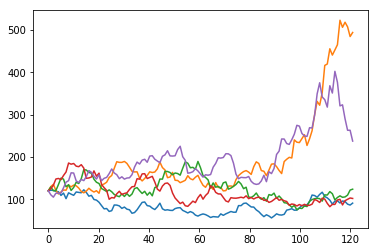

In [22]:
def merton_model_jump_process(V, K, sigma, T, dt, iRate, num_paths, jumps_mu, jumps_sigma, Lambda):
    num_periods = int(T*dt**-1)
    simulated_paths = np.zeros([num_periods+1, num_paths])
    # Replace the first column of the array with the vector of initial price S
    simulated_paths[0] = V
    
    Z_1 = np.random.normal(size=[num_periods+1, num_paths])
    Z_2 = np.random.normal(size=[num_periods+1, num_paths])
    Poisson = np.random.poisson(Lambda*dt, [num_periods+1, num_paths])
    
    rj = Lambda*(np.exp(jumps_mu + 0.5*jumps_sigma**2)-1)

    for t in range(1, num_periods + 1):
        #simulated_paths[t] = simulated_paths[t-1]*np.exp((iRate - 0.5*sigma**2)*dt + sigma*np.sqrt(dt)*Z_1[t] + jumps_mu*Poisson[1] + np.sqrt(jumps_sigma**2) * np.sqrt(Poisson[t])*Z_2[t])
        simulated_paths[t] = simulated_paths[t-1]*(np.exp((iRate - rj - 0.5*sigma**2)*dt + sigma*np.sqrt(dt)*Z_1[t]) + (np.exp(jumps_mu + jumps_sigma*Z_2[t])-1)*Poisson[t])
    asset_values_at_T = simulated_paths[-1, :]
    
    print('Numerical PD: ', 1 - (np.sum(asset_values_at_T > K)/ num_paths), '\n')
    print('Estimated Distribution PD: ', sp.gaussian_kde(np.array(asset_values_at_T)).integrate_box_1d(-np.inf, K))
    
    fig = plt.figure()
    ax = plt.axes()
    x = np.linspace(0, num_periods+1, num=num_periods+1)
    ax.plot(x, simulated_paths[:,np.random.randint(num_paths)],
             x, simulated_paths[:,np.random.randint(num_paths)],
             x, simulated_paths[:,np.random.randint(num_paths)],
             x, simulated_paths[:,np.random.randint(num_paths)],
             x, simulated_paths[:,np.random.randint(num_paths)])
    
    
    return simulated_paths

plot_simulation(merton_model_jump_process(V=120, K=95, iRate=0.028, sigma=.23, T= 10, dt=1/12, num_paths=250000, jumps_mu=0.05, jumps_sigma=0.20, Lambda=.1),
                'Merton Model with Jumps', num_paths=250000)

# Question 3: Dependence Modeling and Gaussian / t-Copulas

### (i) Portfolio and default dependence modeling 

In [23]:
#from pylab import plot, show, axis, subplot, xlabel, ylabel, grid
siz = 30
corr = .15
nsim = 250000
Lambda = .05

cov_matrix = np.zeros((siz,siz)) + corr
np.fill_diagonal(cov_matrix, 1)
#cho = np.linalg.cholesky(cov_matrix)
#print('Cholesky Matrix: ', cho, '\n')
#x = np.random.normal(size=siz)
#generates multivariate normal distributions
x = np.random.multivariate_normal(np.zeros(siz), cov_matrix, size=nsim)
#print('X RVs : ', x, '\n')

#print(x[0, :])
#print('First Dot Product: ', np.dot(cho, x[0,:]))
#print('Second Dot Product: ', np.dot(cho, x[1,:]))
#gamma_normal_array = np.dot(cho, x)
#gamma_normal_array = np.matmul(cho, x)
#gamma_normal_array = np.sum(cho*x, axis=1)
#print('Cholesky * RV: ', gamma_normal_array)
#print('Correlation Check: ', np.corrcoef(gamma_normal_array))
#calculated = x.copy()
#calculated[1] = x[1]*corr + np.sqrt(1-corr**2)*x[1]
#print('Calculated Values: ', x[0], x[1]*corr + np.sqrt(1-corr**2)*x[1])
#plt.plot(gamma_normal_array, 'o', color='black')
#plt.plot(x, 'o', color='blue')
#plt.plot(calculated, 'o', color='red')

cdf_u = sp.norm.cdf(x)
#cdf_u = sp.norm.cdf(gamma_normal_array)
#print('Cumulative Distribution: ', cdf_u)

ti = -1/Lambda*np.log(1-cdf_u)

In [24]:
x[4]

array([ 1.27272346,  0.87403242,  1.08841168,  0.94064784, -1.25588657,
        1.9060867 ,  1.28251521, -0.32329201,  1.54994317,  1.36655966,
        1.06586761,  1.97383458, -0.4308651 , -0.28883319,  1.13428145,
        2.06955994,  1.67544436,  0.27732059, -0.06247606,  1.73148881,
       -0.92825767,  0.0775564 ,  0.39568776, -0.67230494,  2.0487695 ,
       -1.02748334,  1.69516899, -0.8913774 , -1.88976029, -0.63366557])

In [25]:
def multivariate_t_rvs(m, S, df=np.inf, n=1):
    '''generate random variables of multivariate t distribution
    Parameters
    ----------
    m : array_like
        mean of random variable, length determines dimension of random variable
    S : array_like
        square array of covariance  matrix
    df : int or float
        degrees of freedom
    n : int
        number of observations, return random array will be (n, len(m))
    Returns
    -------
    rvs : ndarray, (n, len(m))
        each row is an independent draw of a multivariate t distributed
        random variable
    '''
    m = np.asarray(m)
    d = len(m)
    if df == np.inf:
        x = 1.
    else:
        x = np.random.chisquare(df, n)/df
    z = np.random.multivariate_normal(np.zeros(d),S,(n,))
    return m + z/np.sqrt(x)[:,None]   # same output format as random.multivariate_normal

In [87]:
def copula(num_assets, correlation, Lambda, nsim, distribution):
    # Covariance Matrix plus the correlation; since Mean = 0 and Sigma = 1, they are the same
    cov_matrix = np.zeros((num_assets,num_assets)) + correlation
    np.fill_diagonal(cov_matrix, 1)
    time = input('Time Value: ')
    num_def = input('Number Default Threshold: ')
    if distribution == 'gaussian':
        num_defaulted = 0
        num_non_defaulted = 0
        # Returns the lower triangle Cholesky Matrix as stated in the coursework
        cho = np.linalg.cholesky(cov_matrix)
        #Returns all of the Jointly Distributed RV's with the appropriate Correlation 
        x = np.random.multivariate_normal(np.zeros(num_assets), cov_matrix, size=nsim)
        #x = np.random.normal(size=(nsim, num_assets))
        for sim in range(0, nsim):
            # Multiplys the Cholskey Matrix with the RV's
            rv_arr = np.dot(cho, x[sim])
            # Generates the [0,1] Probabilities of the Correlated RV's
            #plt.plot(rv_arr, 'o', color='black')
            cdf_probabilities = sp.norm.cdf(rv_arr)
            print(cdf_probabilities)
            #tau = np.random.exponential(rv_arr, 1/Lambda)
            
            
            #print(cdf_probabilities)
            #time is in years
            #ti = -1/Lambda*np.log(1 - cdf_u)
            # Generates the sum of all Probabilities = 1.0
            #num_defaulted+= np.sum(cdf_probabilities >= 0.9)
            # Generates all of the probabilites = 0.0
            #num_non_defaulted+= np.sum(cdf_probabilities  < 0.9)
        
    if distribution == 'student-t':
        rv_arr = multivariate_t_rvs(np.zeros(num_assets), S=cov_matrix, df=4, n=nsim)
        
        cdf_probabilities = t.cdf(rv_arr, df=4)
        #print(cdf_probabilities)
        num_defaulted = np.sum(np.sum(cdf_probabilities >= .9, axis=0))
        num_non_defaulted = np.sum(np.sum(cdf_probabilities < .9, axis=0))
    
    print('Coplua Distribution: ', distribution, '\n')
    print('Number of Simulations: ', nsim, '\n')
    print('Correlation: ', correlation, '\n')
    print('Lambda: ', Lambda, '\n')
    print('Number of Defaults: ', num_defaulted, '\n')
    print('Default Percentage: ', num_defaulted/(nsim*num_assets), '\n')
    print('Number of no Defaults: ', num_non_defaulted)
    #plt.plot(cdf_probabilities, 'o', color='blue')
    #plt.plot(rv_arr, 'o', color='black')
    
    return None

In [27]:
copula(num_assets=30, correlation=.15, Lambda=.15, nsim=250, distribution='gaussian')

Coplua Distribution:  gaussian 

Number of Simulations:  250 

Correlation:  0.15 

Lambda:  0.15 

Number of Defaults:  995 

Default Percentage:  0.13266666666666665 

Number of no Defaults:  6505


In [3]:
time = np.arange(1.5, 4.0, .5)
Lambda = .15
num_assets = 30

dta = []
for t in np.arange(1.5, 2.0, .5):
    
    for rho in np.array([0, 0.15, 0.3]):
        num_defaulted_t = []
        cov_matrix = np.zeros((num_assets,num_assets)) + rho
        np.fill_diagonal(cov_matrix, 1)
        cho = np.linalg.cholesky(cov_matrix)
        x = np.random.multivariate_normal(np.zeros(num_assets), cov_matrix, size=250000)
        #num_defaulted_8 = 0
        #num_defaulted_10 = 0
        #num_defaulted_12 = 0
        #num_defaulted_0 = 0
        
        for sim in range(0, 250000):
            RV = np.dot(cho, x[sim])
            cdf_probabilities = sp.norm.cdf(RV)
            #print(cdf_probabilities)
            tau = sp.expon.ppf(cdf_probabilities, scale=(1/Lambda))
            num_defaulted_t.append(np.sum(tau <= t))
    
    num_defaulted_t = np.array(num_defaulted_t)
    print(np.sum(num_defaulted_t >= 8), np.sum(num_defaulted_t >= 10), np.sum(num_defaulted_t >= 12))
    #dta.append([np.sum(num_defaulted_t >= 8), np.sum(num_defaulted_t >= 10), np.sum(num_defaulted_t >= 12)])
print(dta)




'''
base_pi = []
for t_ in time:
    base_pi.append(1-np.exp(-Lambda*t_))
base_pi = np.array(base_pi)
Pi_cdf = sp.norm.cdf(base_pi)
#print(Pi_cdf)
#Yi = np.zeros(s)
Yi = np.array(corr*M + np.sqrt(1-corr**2)*np.random.normal(size=s))

U_cdf = sp.norm.cdf(Yi)
#print(U_cdf)'''

[[255984, 184164, 147680]]


'\nbase_pi = []\nfor t_ in time:\n    base_pi.append(1-np.exp(-Lambda*t_))\nbase_pi = np.array(base_pi)\nPi_cdf = sp.norm.cdf(base_pi)\n#print(Pi_cdf)\n#Yi = np.zeros(s)\nYi = np.array(corr*M + np.sqrt(1-corr**2)*np.random.normal(size=s))\n\nU_cdf = sp.norm.cdf(Yi)\n#print(U_cdf)'

In [6]:
Lambda = .15
num_assets = 30
t = 1.5
for rho in np.array([0, 0.15, 0.3]):
    num_defaults = []
    cov_matrix = np.zeros((num_assets,num_assets)) + rho
    np.fill_diagonal(cov_matrix, 1)
    cho = np.linalg.cholesky(cov_matrix)
    x = np.random.multivariate_normal(np.zeros(num_assets), cov_matrix, size=250000)
    #num_defaulted_8 = 0
    #num_defaulted_10 = 0
    #num_defaulted_12 = 0
    #num_defaulted_0 = 0

    for sim in range(0, 250000):
        RV = np.dot(cho, x[sim])
        cdf_probabilities = sp.norm.cdf(RV)
        #print(cdf_probabilities)
        tau = sp.expon.ppf(cdf_probabilities, scale=(1/Lambda))
        num_defaults.append(np.sum(tau <= t))
    num_defaults = np.array(num_defaults)
    print(np.sum(num_defaults >= 8)/250000*30, np.sum(num_defaults >= 10)/250000*30, np.sum(num_defaults >= 12)/250000*30)

7.37592 1.93164 0.30732
11.49636 9.39852 7.62828
11.93652 10.81332 9.814079999999999


In [ ]:
time = np.arange(1.5, 4.0, .5)
Lambda = .15
num_assets = 30

dta = []
for t in np.arange(1.5, 2.0, .5):
    num_defaulted_t = []
    for rho in np.array([0, 0.15, 0.3]):
        cov_matrix = np.zeros((num_assets,num_assets)) + rho
        np.fill_diagonal(cov_matrix, 1)
        cho = np.linalg.cholesky(cov_matrix)
        x = multivariate_t_rvs(np.zeros(num_assets), S=cov_matrix, df=4, n=250000)
        #num_defaulted_8 = 0
        #num_defaulted_10 = 0
        #num_defaulted_12 = 0
        #num_defaulted_0 = 0
        
        for sim in range(0, 250000):
            RV = np.dot(cho, x[sim])
            cdf_probabilities = t.cdf(RV, df=4)
            #print(cdf_probabilities)
            tau = sp.expon.ppf(cdf_probabilities, scale=(1/Lambda))
            #num_defaulted_t.append(np.sum(tau <= t))
    
    num_defaulted_t = np.array(num_defaulted_t)
    dta.append([np.sum(num_defaulted_t >= 8), np.sum(num_defaulted_t >= 10), np.sum(num_defaulted_t >= 12)])
print(dta)

In [78]:
np.arange(1.5, 2.0, .5)

array([1.5])

In [29]:
'''
M = np.random.standard_t(4)
s = 250000
base_pi = []
for t_ in time:
    base_pi.append(1-np.exp(-Lambda*t_))
base_pi = np.array(base_pi)
print(base_pi)
t.cdf()
Pi_cdf = t.cdf(base_pi)
#Yi = np.zeros(s)
Yi = np.array(corr*M + np.sqrt(1-corr**2)*np.random.standard_t(df=4, size=s))

U_cdf = t.cdf(Yi)
'''

'\nM = np.random.standard_t(4)\ns = 250000\nbase_pi = []\nfor t_ in time:\n    base_pi.append(1-np.exp(-Lambda*t_))\nbase_pi = np.array(base_pi)\nprint(base_pi)\nt.cdf()\nPi_cdf = t.cdf(base_pi)\n#Yi = np.zeros(s)\nYi = np.array(corr*M + np.sqrt(1-corr**2)*np.random.standard_t(df=4, size=s))\n\nU_cdf = t.cdf(Yi)\n'

In [30]:
month_18 = np.sum(U_cdf <= Pi_cdf[0])
month_24 = np.sum(U_cdf <= Pi_cdf[1])
month_30 = np.sum(U_cdf <= Pi_cdf[2])
month_36 = np.sum(U_cdf <= Pi_cdf[3])
month_42 = np.sum(U_cdf <= Pi_cdf[4])

In [31]:
print(month_18/s)
print(month_24/s)
print(month_30/s)
print(month_36/s)
print(month_42/s)

0.602836
0.626628
0.648184
0.667576
0.684724


In [32]:
print('Number of Zero Defaults: ', np.sum(np.sum(cdf_u == 0, axis=1)))
print('NUmber of Defaults: ', np.sum(np.sum(cdf_u == 1, axis=1)))

Number of Zero Defaults:  0
NUmber of Defaults:  0
